In [1]:
import gc
import utils
import duckdb
import pandas as pd
import plotly.io as pio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# jupysql is a requirement too

In [2]:
# Matplotlib config
plt.style.use('default')
plt.rcParams.update({
    "font.family":       "serif",
    "font.serif":        ["Times New Roman", "Palatino", "STIX"],
    "mathtext.fontset":  "stix",         # use STIX fonts for math
    "text.usetex":       False,          # or True if you have LaTeX installed

    # 2) Axis titles and tick labels
    "axes.labelsize":    14,
    "axes.titlesize":    16,
    "xtick.labelsize":   12,
    "ytick.labelsize":   12,
    "xtick.direction":   "out",
    "ytick.direction":   "out",

    # 3) Grid style
    "axes.grid":         False,
    "grid.color":        "0.8",          # light grey
    "grid.linestyle":    "--",
    "grid.linewidth":    0.5,

    # 4) Legend styling
    "legend.frameon":    True,
    "legend.framealpha": 0.9,
    "legend.edgecolor":  "0.8",
    "legend.fontsize":   12,
})

In [3]:
utils.db_setup('rel-f1', 'f1.db')
utils.db_setup('rel-avito', 'avito.db')
utils.db_setup('rel-hm', 'hm.db')
utils.db_setup('rel-stack', 'stack.db')
utils.db_setup('rel-trial', 'trial.db')

Loading Database object from /Users/ignacunado/Library/Caches/relbench/rel-f1/db...
Done in 0.07 seconds.
Catalog Error: Table with name "races" already exists!
Loading Database object from /Users/ignacunado/Library/Caches/relbench/rel-avito/db...
Done in 1.60 seconds.
Catalog Error: Table with name "AdsInfo" already exists!
Loading Database object from /Users/ignacunado/Library/Caches/relbench/rel-hm/db...
Done in 0.44 seconds.
Catalog Error: Table with name "article" already exists!
Loading Database object from /Users/ignacunado/Library/Caches/relbench/rel-stack/db...
Done in 2.99 seconds.
Catalog Error: Table with name "users" already exists!
Loading Database object from /Users/ignacunado/Library/Caches/relbench/rel-trial/db...
Done in 2.18 seconds.
Catalog Error: Table with name "studies" already exists!


# F1

In [4]:
conn = duckdb.connect('f1.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True
pio.renderers.default = 'svg'

In [5]:
%%sql train_df <<
from driver_position_train

In [6]:
%%sql test_df <<
from driver_position_test

In [7]:
%%sql val_df <<
from driver_position_val

In [8]:
train_df.describe()

,date,driverId,position
count,7453,7453.000000,7453.000000
mean,1977-07-01 23:41:38.698510656,262.155105,13.901438
min,1950-06-19 00:00:00,1.000000,1.000000
25%,1964-04-06 00:00:00,108.000000,9.000000
50%,1977-11-24 00:00:00,208.000000,13.333333
75%,1990-05-20 00:00:00,374.000000,18.000000
max,2004-09-03 00:00:00,806.000000,39.000000
std,NaN,192.276916,7.025734


In [9]:
test_df.describe()

,date,driverId,position
count,760,760.000000,760.000000
mean,2013-02-25 03:09:28.421052672,369.565789,11.926206
min,2010-03-02 00:00:00,0.000000,1.000000
25%,2011-06-25 00:00:00,12.000000,8.000000
50%,2013-02-14 00:00:00,109.000000,12.183333
75%,2014-10-07 00:00:00,815.000000,16.000000
max,2016-05-29 00:00:00,837.000000,24.000000
std,NaN,391.605783,5.213817


In [10]:
val_df.describe()

,date,driverId,position
count,499,499.000000,499.000000
mean,2007-07-08 09:31:22.965931776,17.146293,11.083200
min,2005-03-02 00:00:00,0.000000,1.000000
25%,2006-04-26 00:00:00,7.000000,7.550000
50%,2007-08-19 00:00:00,15.000000,11.400000
75%,2008-08-13 00:00:00,21.000000,14.666667
max,2009-10-07 00:00:00,154.000000,22.000000
std,NaN,18.703044,4.640726


In [11]:
driver_pos_train_labels = train_df['position'].to_numpy()
driver_pos_test_labels = test_df['position'].to_numpy()
driver_pos_val_labels = val_df['position'].to_numpy()

In [12]:
def plot_reg_dist(ax, data, xlabel, ylabel, title):
    mean = np.mean(data)
    ax.hist(data, bins='auto', color='#B3EBF2')
    ax.axvline(mean, label='Mean', color='r')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

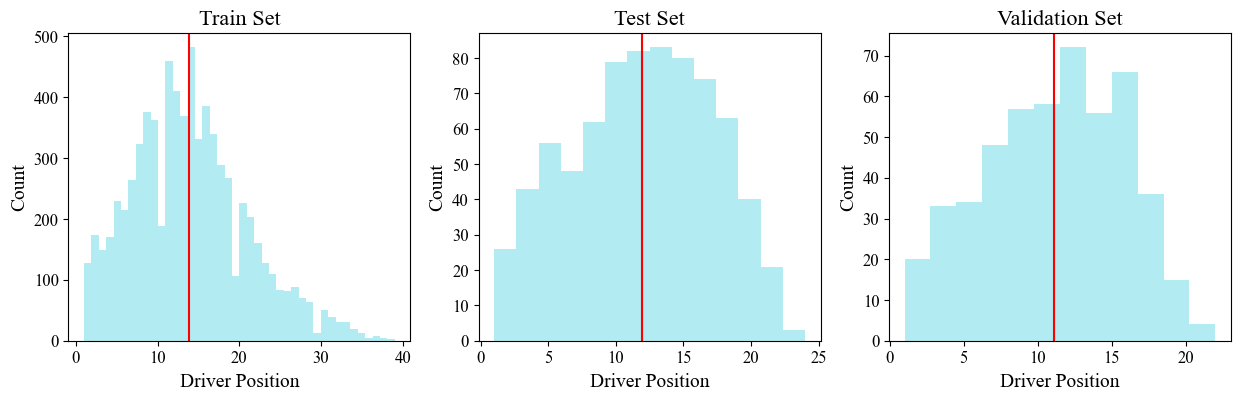

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

xlabel = 'Driver Position'
ylabel = 'Count'

plot_reg_dist(ax[0], driver_pos_train_labels, xlabel, ylabel, 'Train Set')
plot_reg_dist(ax[1], driver_pos_test_labels, xlabel, ylabel, 'Test Set')
plot_reg_dist(ax[2], driver_pos_val_labels, xlabel, ylabel, 'Validation Set')

plt.savefig('driver_position_dist.pdf')
plt.show()

## Percentage of labels > 24

In [14]:
over_24 =  driver_pos_train_labels[driver_pos_train_labels >= 24]
percentage = (len(over_24) / len(driver_pos_train_labels))* 100
percentage

9.445860727223938

In [15]:
over_24_mean = over_24.mean()
diff = over_24_mean - 24
diff

np.float64(4.071898674242423)

In [16]:
%%sql train_df <<
from driver_top3_train

In [17]:
%%sql test_df <<
from driver_top3_test

In [18]:
%%sql val_df <<
from driver_top3_val

In [19]:
train_df.describe()

,date,driverId,qualifying
count,1353,1353.000000,1353.000000
mean,1998-10-03 08:37:15.033259392,49.562454,0.170732
min,1994-02-28 00:00:00,1.000000,0.000000
25%,1995-05-24 00:00:00,22.000000,0.000000
50%,1997-07-12 00:00:00,49.000000,0.000000
75%,2003-03-13 00:00:00,70.000000,0.000000
max,2004-10-03 00:00:00,115.000000,1.000000
std,NaN,28.320688,0.376413


In [20]:
test_df.describe()

,date,driverId,qualifying
count,726,726.000000,726.000000
mean,2011-08-04 06:56:31.735537152,252.154270,0.176309
min,2010-03-02 00:00:00,0.000000,0.000000
25%,2010-09-28 00:00:00,12.000000,0.000000
50%,2011-07-25 00:00:00,23.000000,0.000000
75%,2012-05-20 00:00:00,808.000000,0.000000
max,2013-03-16 00:00:00,823.000000,1.000000
std,NaN,353.641273,0.381345


In [21]:
val_df.describe()

,date,driverId,qualifying
count,588,588.000000,588.000000
mean,2006-08-23 00:44:04.897959168,17.204082,0.202381
min,2005-03-02 00:00:00,0.000000,0.000000
25%,2005-09-28 00:00:00,10.000000,0.000000
50%,2006-07-25 00:00:00,17.000000,0.000000
75%,2007-06-20 00:00:00,24.000000,0.000000
max,2008-03-16 00:00:00,41.000000,1.000000
std,NaN,10.284000,0.402117


In [22]:
top3_train_labels = train_df.qualifying.to_numpy()
top3_test_labels = test_df.qualifying.to_numpy()
top3_val_labels = test_df.qualifying.to_numpy()

In [23]:
def plot_binary_dist(ax, data, ylabel, title):
    counts = np.bincount(data)           # [num_zero, num_one]
    pct = counts / counts.sum()   # fractions
    bars = ax.bar([0, 1], counts, tick_label=["Negative (0)", "Positive (1)"], color=['#FF6961', '#77DD77'])
    for bar, p in zip(bars, pct):
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"{p*100:.1f}%",
            ha="center",
            va="bottom",
            fontweight="bold"
        )
    ax.set_ylabel(ylabel)
    ax.set_title(title)

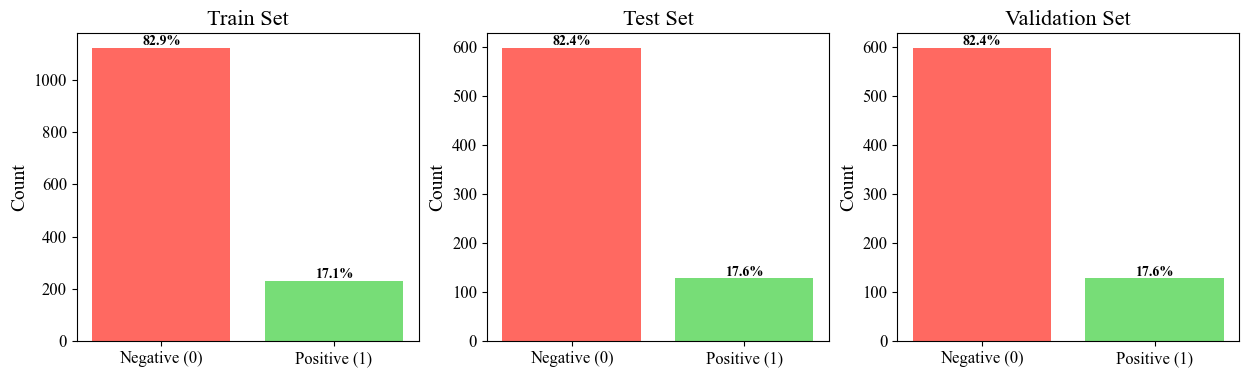

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_binary_dist(ax[0], top3_train_labels, 'Count', 'Train Set')
plot_binary_dist(ax[1], top3_test_labels, 'Count', 'Test Set')
plot_binary_dist(ax[2], top3_val_labels, 'Count', 'Validation Set')

plt.savefig('driver_top3_dist.pdf')
plt.show()

In [25]:
%%sql train_df <<
from driver_dnf_train

In [26]:
%%sql test_df <<
from driver_dnf_test

In [27]:
%%sql val_df <<
from driver_dnf_val

In [28]:
dnf_train_labels = train_df.did_not_finish.to_numpy()
dnf_test_labels = test_df.did_not_finish.to_numpy()
dnf_val_labels = val_df.did_not_finish.to_numpy()

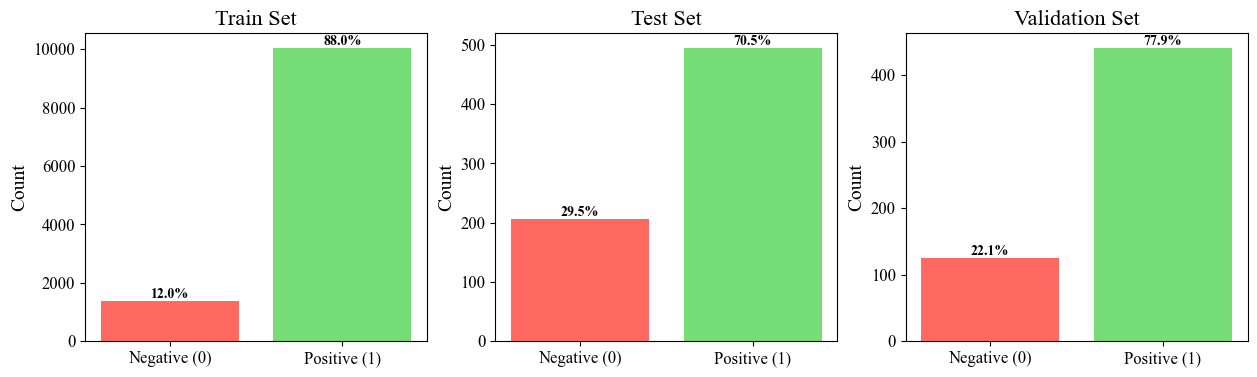

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_binary_dist(ax[0], dnf_train_labels, 'Count', 'Train Set')
plot_binary_dist(ax[1], dnf_test_labels, 'Count', 'Test Set')
plot_binary_dist(ax[2], dnf_val_labels, 'Count', 'Validation Set')

plt.savefig('driver_dnf_dist.pdf')
plt.show()

In [30]:
conn.close()
gc.collect()

21978

# HM


In [31]:
conn = duckdb.connect('hm.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True
pio.renderers.default = 'svg'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [32]:
%%sql train_df <<
from user_churn_train

In [33]:
%%sql test_df <<
from user_churn_test

In [34]:
%%sql val_df <<
from user_churn_val

In [35]:
train_df.describe()

,timestamp,customer_id,churn
count,3832692,3.832692e+06,3.832692e+06
mean,2020-03-10 00:31:28.644325632,6.857392e+05,8.187324e-01
min,2019-09-09 00:00:00,0.000000e+00,0.000000e+00
25%,2019-12-02 00:00:00,3.428740e+05,1.000000e+00
50%,2020-03-09 00:00:00,6.855210e+05,1.000000e+00
75%,2020-06-15 00:00:00,1.028411e+06,1.000000e+00
max,2020-08-31 00:00:00,1.371979e+06,1.000000e+00
std,NaN,3.962903e+05,3.852398e-01


In [36]:
test_df.describe()

,timestamp,customer_id,churn
count,74575,7.457500e+04,74575.000000
mean,2020-09-14 00:00:00,6.848040e+05,0.826135
min,2020-09-14 00:00:00,6.000000e+00,0.000000
25%,2020-09-14 00:00:00,3.417305e+05,1.000000
50%,2020-09-14 00:00:00,6.817150e+05,1.000000
75%,2020-09-14 00:00:00,1.028838e+06,1.000000
max,2020-09-14 00:00:00,1.371977e+06,1.000000
std,NaN,3.962824e+05,0.378996


In [37]:
val_df.describe()

,timestamp,customer_id,churn
count,76556,7.655600e+04,76556.000000
mean,2020-09-07 00:00:00,6.840053e+05,0.812804
min,2020-09-07 00:00:00,0.000000e+00,0.000000
25%,2020-09-07 00:00:00,3.402850e+05,1.000000
50%,2020-09-07 00:00:00,6.849775e+05,1.000000
75%,2020-09-07 00:00:00,1.024983e+06,1.000000
max,2020-09-07 00:00:00,1.371975e+06,1.000000
std,NaN,3.960435e+05,0.390072


In [38]:
user_churn_train_labels = train_df.churn.to_numpy()
user_churn_test_labels = test_df.churn.to_numpy()
user_churn_val_labels = val_df.churn.to_numpy()

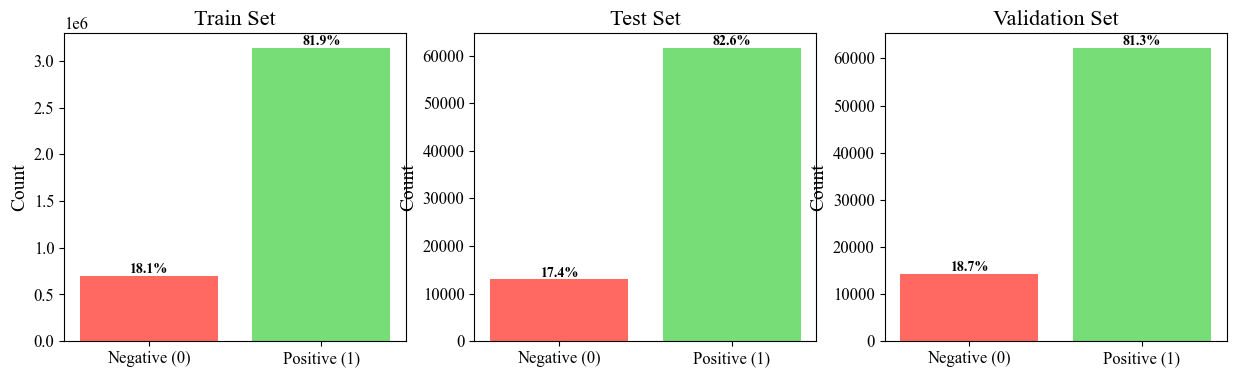

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_binary_dist(ax[0], user_churn_train_labels, 'Count', 'Train Set')
plot_binary_dist(ax[1], user_churn_test_labels, 'Count', 'Test Set')
plot_binary_dist(ax[2], user_churn_val_labels, 'Count', 'Validation Set')

plt.savefig('user_churn_dist.pdf')
plt.show()

In [40]:
%%sql train_df <<
from item_sales_train

In [41]:
%%sql test_df <<
from item_sales_test

In [42]:
%%sql val_df <<
from item_sales_val

In [43]:
train_df.head()

,timestamp,article_id,sales
0,2020-06-01,83325,2.728000
1,2020-06-01,50838,0.758051
2,2020-06-01,86874,1.337610
3,2020-06-01,89952,1.306220
4,2020-06-01,79129,0.271119


In [44]:
train_df.describe()

,timestamp,article_id,sales
count,5488184,5.488184e+06,5.488184e+06
mean,2020-03-05 12:00:00.000000512,5.277050e+04,7.596521e-02
min,2019-09-09 00:00:00,0.000000e+00,0.000000e+00
25%,2019-12-07 06:00:00,2.638500e+04,0.000000e+00
50%,2020-03-05 12:00:00,5.277050e+04,0.000000e+00
75%,2020-06-02 18:00:00,7.915600e+04,0.000000e+00
max,2020-08-31 00:00:00,1.055410e+05,8.716259e+01
std,NaN,3.046735e+04,4.953213e-01


In [45]:
test_df.describe()

,timestamp,article_id,sales
count,105542,105542.000000,105542.000000
mean,2020-09-14 00:00:00,52770.500000,0.076087
min,2020-09-14 00:00:00,0.000000,0.000000
25%,2020-09-14 00:00:00,26385.250000,0.000000
50%,2020-09-14 00:00:00,52770.500000,0.000000
75%,2020-09-14 00:00:00,79155.750000,0.000000
max,2020-09-14 00:00:00,105541.000000,38.314763
std,NaN,30467.495393,0.582710


In [46]:
val_df.describe()

,timestamp,article_id,sales
count,105542,105542.000000,105542.000000
mean,2020-09-07 00:00:00,52770.500000,0.085690
min,2020-09-07 00:00:00,0.000000,0.000000
25%,2020-09-07 00:00:00,26385.250000,0.000000
50%,2020-09-07 00:00:00,52770.500000,0.000000
75%,2020-09-07 00:00:00,79155.750000,0.000000
max,2020-09-07 00:00:00,105541.000000,40.364915
std,NaN,30467.495393,0.662294


In [47]:
item_sales_train_labels = train_df.sales.to_numpy()
item_sales_test_labels = test_df.sales.to_numpy()
item_sales_val_labels = val_df.sales.to_numpy()

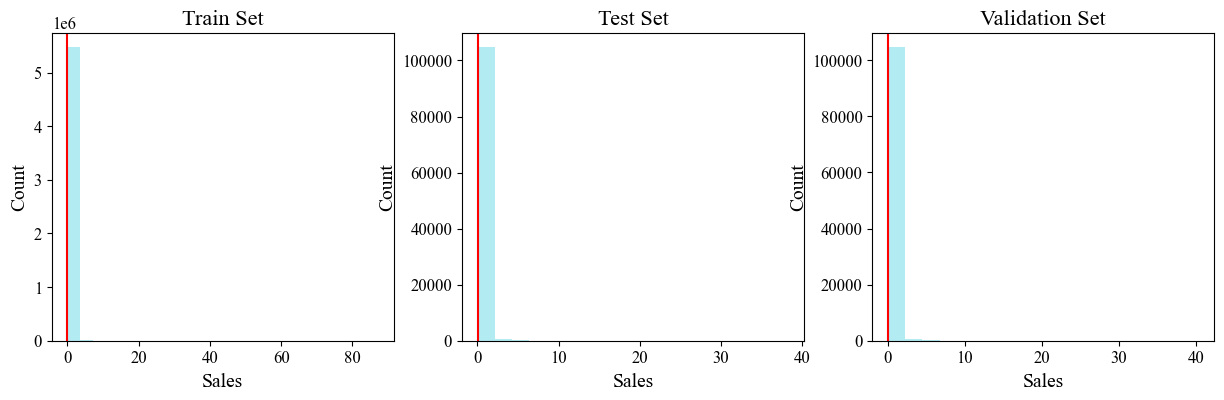

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_reg_dist(ax[0], item_sales_train_labels, 'Sales', 'Count', 'Train Set')
plot_reg_dist(ax[1], item_sales_test_labels, 'Sales', 'Count', 'Test Set')
plot_reg_dist(ax[2], item_sales_val_labels, 'Sales', 'Count', 'Validation Set')

plt.savefig('item_sales_dist.pdf')
plt.show()

/var/folders/0x/klqdyhpj427dvg81kxzyfcvm0000gn/T/ipykernel_93281/3553351894.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




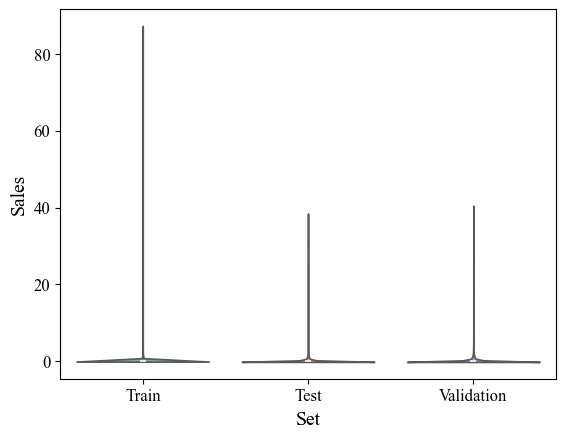

In [49]:
sales = np.concatenate([item_sales_train_labels, item_sales_test_labels, item_sales_val_labels])
sets = (['Train'] * len(item_sales_train_labels)) + (['Test'] * len(item_sales_test_labels)) + (['Validation'] * len(item_sales_val_labels))

df = pd.DataFrame({'Sales': sales, 'Set': sets})

fig, ax = plt.subplots()
sns.violinplot(x='Set', y='Sales', data=df, ax=ax, palette='Set2')

plt.savefig('item_sales_violinplot.pdf')
plt.show()

In [50]:
conn.close()
gc.collect()

29308

# Avito

In [51]:
conn = duckdb.connect('avito.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True
pio.renderers.default = 'svg'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [52]:
%%sql train_df <<
from user_visits_train

In [53]:
%%sql test_df <<
from user_visits_test

In [54]:
%%sql val_df <<
from user_visits_val

In [55]:
train_df.head()

,UserID,timestamp,num_click
0,38950,2015-04-26,True
1,35404,2015-04-26,True
2,85455,2015-04-26,True
3,2871,2015-04-26,True
4,34600,2015-04-26,True


In [56]:
train_df['num_click'] = train_df['num_click'].astype(int)
test_df['num_click'] = test_df['num_click'].astype(int)
val_df['num_click']= val_df['num_click'].astype(int)

train_df.head()

,UserID,timestamp,num_click
0,38950,2015-04-26,1
1,35404,2015-04-26,1
2,85455,2015-04-26,1
3,2871,2015-04-26,1
4,34600,2015-04-26,1


In [57]:
train_df.describe()

,UserID,timestamp,num_click
count,86619.000000,86619,86619.000000
mean,49188.634145,2015-04-30 03:32:15.718491392,0.905887
min,0.000000,2015-04-26 00:00:00,0.000000
25%,24546.000000,2015-04-26 00:00:00,1.000000
50%,49155.000000,2015-04-30 00:00:00,1.000000
75%,73782.000000,2015-05-04 00:00:00,1.000000
max,98217.000000,2015-05-04 00:00:00,1.000000
std,28340.510626,NaN,0.291988


In [58]:
test_df.describe()

,UserID,timestamp,num_click
count,36129.000000,36129,36129.000000
mean,49140.150267,2015-05-14 00:00:00,0.850591
min,3.000000,2015-05-14 00:00:00,0.000000
25%,24634.000000,2015-05-14 00:00:00,1.000000
50%,49071.000000,2015-05-14 00:00:00,1.000000
75%,73700.000000,2015-05-14 00:00:00,1.000000
max,98139.000000,2015-05-14 00:00:00,1.000000
std,28335.916937,NaN,0.356496


In [59]:
val_df.describe()

,UserID,timestamp,num_click
count,29979.000000,29979,29979.000000
mean,48963.380366,2015-05-08 00:00:00,0.903499
min,3.000000,2015-05-08 00:00:00,0.000000
25%,24184.500000,2015-05-08 00:00:00,1.000000
50%,48899.000000,2015-05-08 00:00:00,1.000000
75%,73513.000000,2015-05-08 00:00:00,1.000000
max,98136.000000,2015-05-08 00:00:00,1.000000
std,28338.941071,NaN,0.295282


In [60]:
user_visits_train_labels = train_df.num_click.to_numpy()
user_visits_test_labels = test_df.num_click.to_numpy()
user_visits_val_labels = val_df.num_click.to_numpy()

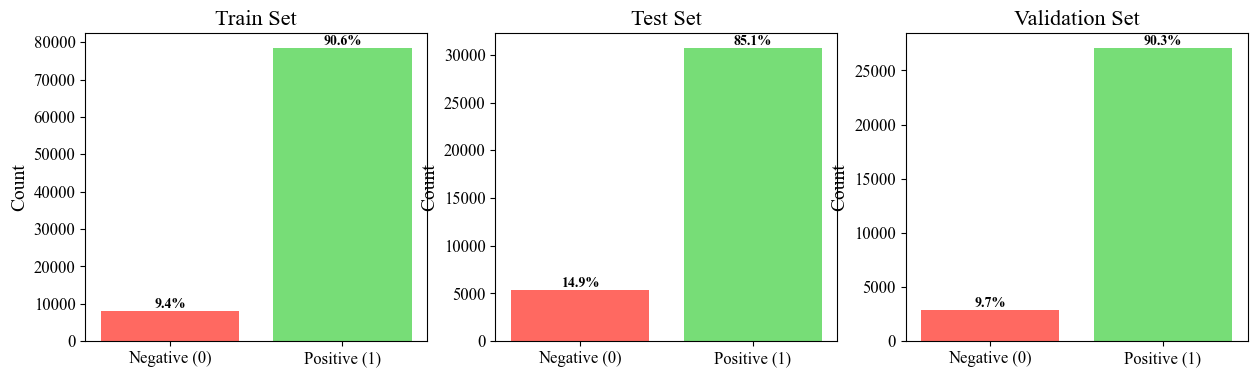

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_binary_dist(ax[0], user_visits_train_labels, 'Count', 'Train Set')
plot_binary_dist(ax[1], user_visits_test_labels, 'Count', 'Test Set')
plot_binary_dist(ax[2], user_visits_val_labels, 'Count', 'Validation Set')

plt.savefig('user_visits_dist.pdf')
plt.show()

In [62]:
%%sql all_joined <<
SELECT
-- from SearchInfo / SearchStream
SI.SearchID,
SI.UserID,
SI.IPID       AS SearchIPID,
SI.SearchDate,
SI.IsUserLoggedOn,
SI.SearchQuery,
SI.LocationID AS SearchLocationID,
SI.CategoryID AS SearchCategoryID,

SS.AdID,
SS.Position,
SS.ObjectType,
SS.HistCTR,
SS.IsClick,

-- from AdsInfo
A.Price,
A.Title,
A.IsContext,
A.LocationID AS AdLocationID,
A.CategoryID AS AdCategoryID,

-- from Category (via AdCategoryID)
C.Level         AS AdCategoryLevel,
C.ParentCategoryID,
C.SubcategoryID,

-- from Location (via AdLocationID)
L.Level         AS AdLocationLevel,
L.RegionID      AS AdRegionID,
L.CityID        AS AdCityID,

-- from UserInfo
U.UserAgentID,
U.UserAgentOSID,
U.UserAgentFamilyID,
U.UserDeviceID,

-- from VisitStream (may be NULL)
VS.ViewDate     AS VisitDate,

-- from PhoneRequestsStream (may be NULL)
PRS.PhoneRequestDate

FROM SearchStream SS
JOIN SearchInfo       SI  USING (SearchID)
JOIN AdsInfo          A   USING (AdID)
JOIN Category         C   ON A.CategoryID = C.CategoryID
JOIN Location         L   ON A.LocationID = L.LocationID
JOIN UserInfo         U   USING (UserID)
LEFT JOIN VisitStream VS  ON VS.UserID = U.UserID
AND VS.AdID   = A.AdID
LEFT JOIN PhoneRequestsStream PRS
ON PRS.UserID = U.UserID
AND PRS.AdID   = A.AdID
;

In [63]:
all_joined.head()

,SearchID,UserID,SearchIPID,SearchDate,IsUserLoggedOn,SearchQuery,SearchLocationID,SearchCategoryID,AdID,Position,...,SubcategoryID,AdLocationLevel,AdRegionID,AdCityID,UserAgentID,UserAgentOSID,UserAgentFamilyID,UserDeviceID,VisitDate,PhoneRequestDate
0,1593598,38731,754962.0,2015-05-11 07:48:27,1.0,None,418,57,491536,7.0,...,37,3.0,54.0,454.0,33726.0,20.0,62.0,2014.0,2015-05-08 17:24:56,NaT
1,770902,38893,376158.0,2015-05-03 15:50:57,0.0,None,21,34,491550,8.0,...,7,3.0,33.0,2391.0,12505.0,20.0,85.0,2014.0,2015-05-03 14:17:38,NaT
2,1694708,21528,1882135.0,2015-05-11 22:25:05,0.0,None,401,34,491552,2.0,...,7,3.0,67.0,618.0,29432.0,20.0,15.0,2014.0,2015-05-11 22:24:46,NaT
3,931459,10729,271955.0,2015-05-04 23:44:02,0.0,None,259,4,491554,2.0,...,39,3.0,4.0,2142.0,23919.0,7.0,7.0,2014.0,2015-05-04 23:43:50,NaT
4,1084277,66701,2097689.0,2015-05-06 11:35:42,0.0,None,341,38,491595,2.0,...,44,3.0,19.0,1850.0,44052.0,20.0,25.0,2014.0,2015-05-06 11:35:53,NaT


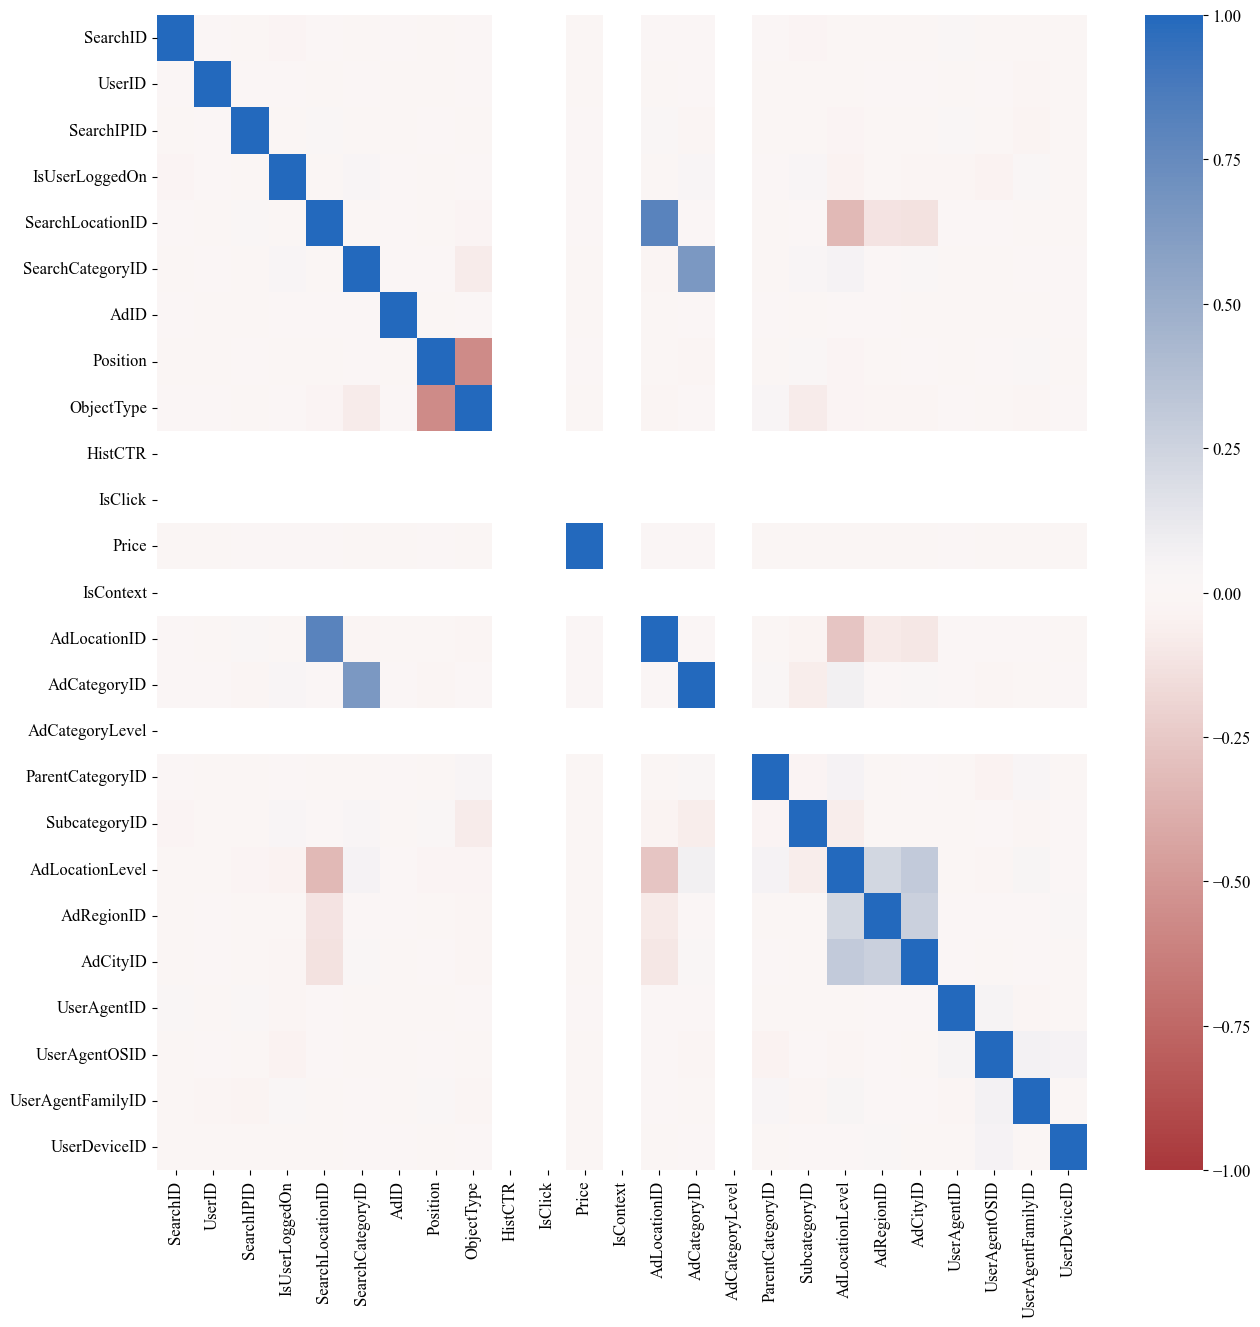

In [64]:
plt.subplots(figsize=(15,15))
sns.heatmap(all_joined.corr(numeric_only=True), cmap = 'vlag_r', vmin = -1, vmax = 1)

plt.savefig('avito_user_visits.pdf')
plt.show()

In [65]:
%%sql train_df <<
from ad_ctr_train

In [66]:
%%sql test_df <<
from ad_ctr_test

In [67]:
%%sql val_df <<
from ad_ctr_val

In [68]:
train_df.describe()

,AdID,timestamp,num_click
count,5.100000e+03,5100,5100.000000
mean,3.015543e+06,2015-04-30 09:24:42.352941312,0.044565
min,2.410000e+02,2015-04-26 00:00:00,0.000517
25%,1.560212e+06,2015-04-26 00:00:00,0.008197
50%,3.022963e+06,2015-04-30 00:00:00,0.017857
75%,4.506267e+06,2015-05-04 00:00:00,0.041667
max,5.928415e+06,2015-05-04 00:00:00,1.000000
std,1.695615e+06,NaN,0.095675


In [69]:
test_df.describe()

,AdID,timestamp,num_click
count,1.816000e+03,1816,1816.000000
mean,2.953207e+06,2015-05-14 00:00:00,0.052210
min,4.659000e+03,2015-05-14 00:00:00,0.000847
25%,1.483985e+06,2015-05-14 00:00:00,0.008736
50%,2.926594e+06,2015-05-14 00:00:00,0.018913
75%,4.436748e+06,2015-05-14 00:00:00,0.046032
max,5.919483e+06,2015-05-14 00:00:00,1.000000
std,1.703636e+06,NaN,0.109783


In [70]:
val_df.describe()

,AdID,timestamp,num_click
count,1.766000e+03,1766,1766.000000
mean,3.011808e+06,2015-05-08 00:00:00,0.048414
min,7.344000e+03,2015-05-08 00:00:00,0.000913
25%,1.529616e+06,2015-05-08 00:00:00,0.007897
50%,2.978298e+06,2015-05-08 00:00:00,0.017911
75%,4.485061e+06,2015-05-08 00:00:00,0.045455
max,5.928415e+06,2015-05-08 00:00:00,1.000000
std,1.717176e+06,NaN,0.099229


In [71]:
ad_ctr_train_labels = train_df.num_click.to_numpy()
ad_ctr_test_labels = test_df.num_click.to_numpy()
ad_ctr_val_labels = val_df.num_click.to_numpy()

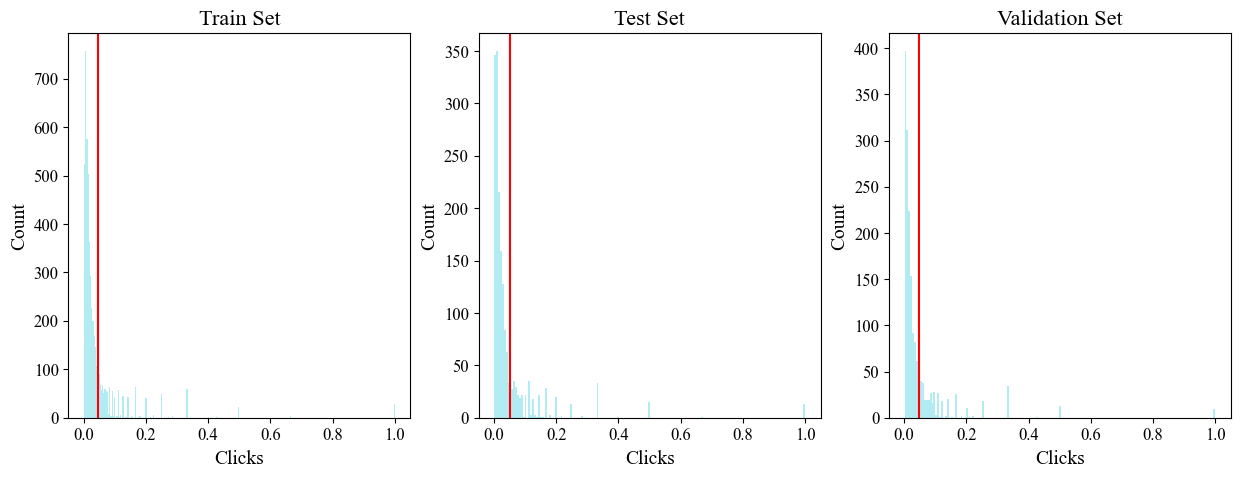

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.reshape((-1))

plot_reg_dist(ax[0], ad_ctr_train_labels, 'Clicks', 'Count', 'Train Set')
plot_reg_dist(ax[1], ad_ctr_test_labels, 'Clicks', 'Count', 'Test Set')
plot_reg_dist(ax[2], ad_ctr_val_labels, 'Clicks', 'Count', 'Validation Set')

plt.savefig('ad_ctr_dist.pdf')
plt.show()

/var/folders/0x/klqdyhpj427dvg81kxzyfcvm0000gn/T/ipykernel_93281/3687178721.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




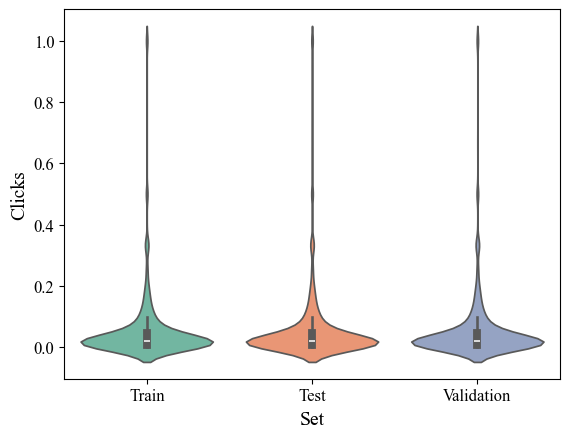

In [73]:
clicks = np.concatenate([ad_ctr_test_labels, ad_ctr_test_labels, ad_ctr_test_labels])
sets = (['Train'] * len(ad_ctr_test_labels)) + (['Test'] * len(ad_ctr_test_labels)) + (['Validation'] * len(ad_ctr_test_labels))

df = pd.DataFrame({'Clicks': clicks, 'Set': sets})

fig, ax = plt.subplots()
sns.violinplot(x='Set', y='Clicks', data=df, ax=ax, palette='Set2')

plt.savefig('ad_ctr_violinplot.pdf')
plt.show()

In [74]:
conn.close()
gc.collect()

44629

# Trial


In [75]:
conn = duckdb.connect('trial.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True
pio.renderers.default = 'svg'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [76]:
%%sql train_df <<
from study_outcome_train

In [77]:
%%sql test_df <<
from study_outcome_test

In [78]:
%%sql val_df <<
from study_outcome_val

In [79]:
train_df.describe()

,timestamp,nct_id,outcome
count,11994,11994.000000,11994.000000
mean,2013-09-16 11:37:11.315657984,92576.491662,0.637569
min,2001-01-05 00:00:00,49.000000,0.000000
25%,2011-01-03 00:00:00,46118.000000,0.000000
50%,2014-01-02 00:00:00,86324.500000,1.000000
75%,2017-01-01 00:00:00,135772.750000,1.000000
max,2019-01-01 00:00:00,217762.000000,1.000000
std,NaN,54858.809190,0.480722


In [80]:
test_df.describe()

,timestamp,nct_id,outcome
count,825,825.000000,825.000000
mean,2021-01-01 00:00:00,199249.295758,0.585455
min,2021-01-01 00:00:00,14479.000000,0.000000
25%,2021-01-01 00:00:00,177202.000000,0.000000
50%,2021-01-01 00:00:00,211407.000000,1.000000
75%,2021-01-01 00:00:00,231650.000000,1.000000
max,2021-01-01 00:00:00,249609.000000,1.000000
std,NaN,43653.289978,0.492942


In [81]:
val_df.describe()

,timestamp,nct_id,outcome
count,960,960.000000,960.000000
mean,2020-01-01 00:00:00,185996.045833,0.584375
min,2020-01-01 00:00:00,2301.000000,0.000000
25%,2020-01-01 00:00:00,164325.000000,0.000000
50%,2020-01-01 00:00:00,197395.000000,1.000000
75%,2020-01-01 00:00:00,215933.750000,1.000000
max,2020-01-01 00:00:00,234361.000000,1.000000
std,NaN,40056.595518,0.493086


In [82]:
study_outcome_train_labels = train_df.outcome.to_numpy()
study_outcome_test_labels = test_df.outcome.to_numpy()
study_outcome_val_labels = val_df.outcome.to_numpy()

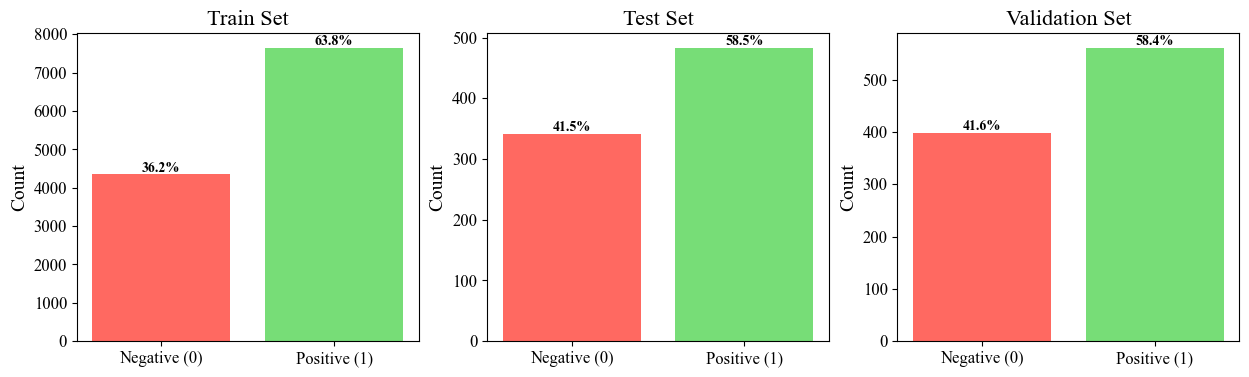

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_binary_dist(ax[0], study_outcome_train_labels, 'Count', 'Train Set')
plot_binary_dist(ax[1], study_outcome_test_labels, 'Count', 'Test Set')
plot_binary_dist(ax[2], study_outcome_val_labels, 'Count', 'Validation Set')

plt.savefig('study_outcome_dist.pdf')
plt.show()

In [84]:
%%sql train_df <<
from site_success_train

In [85]:
%%sql test_df <<
from site_success_test

In [86]:
%%sql val_df <<
from site_success_val

In [87]:
train_df.describe()

,timestamp,facility_id,success_rate
count,151407,151407.000000,151407.000000
mean,2014-12-05 14:37:31.346371072,148505.767996,0.442396
min,2001-01-05 00:00:00,1.000000,0.000000
25%,2013-01-02 00:00:00,35745.500000,0.000000
50%,2015-01-02 00:00:00,110521.000000,0.000000
75%,2018-01-01 00:00:00,254082.500000,1.000000
max,2019-01-01 00:00:00,453211.000000,1.000000
std,NaN,131004.067856,0.475863


In [88]:
test_df.describe()

,timestamp,facility_id,success_rate
count,22617,22617.000000,22617.000000
mean,2021-01-01 00:00:00,155604.373613,0.462222
min,2021-01-01 00:00:00,1.000000,0.000000
25%,2021-01-01 00:00:00,34393.000000,0.000000
50%,2021-01-01 00:00:00,118894.000000,0.166667
75%,2021-01-01 00:00:00,259463.000000,1.000000
max,2021-01-01 00:00:00,453227.000000,1.000000
std,NaN,137467.358421,0.481231


In [89]:
val_df.describe()

,timestamp,facility_id,success_rate
count,19740,19740.000000,19740.000000
mean,2020-01-01 00:00:00,158304.955218,0.474937
min,2020-01-01 00:00:00,1.000000,0.000000
25%,2020-01-01 00:00:00,36905.750000,0.000000
50%,2020-01-01 00:00:00,128224.500000,0.400000
75%,2020-01-01 00:00:00,269598.500000,1.000000
max,2020-01-01 00:00:00,452806.000000,1.000000
std,NaN,130859.318094,0.477706


In [90]:
site_success_train_labels = train_df.success_rate.to_numpy()
site_success_test_labels = test_df.success_rate.to_numpy()
site_success_val_labels = val_df.success_rate.to_numpy()

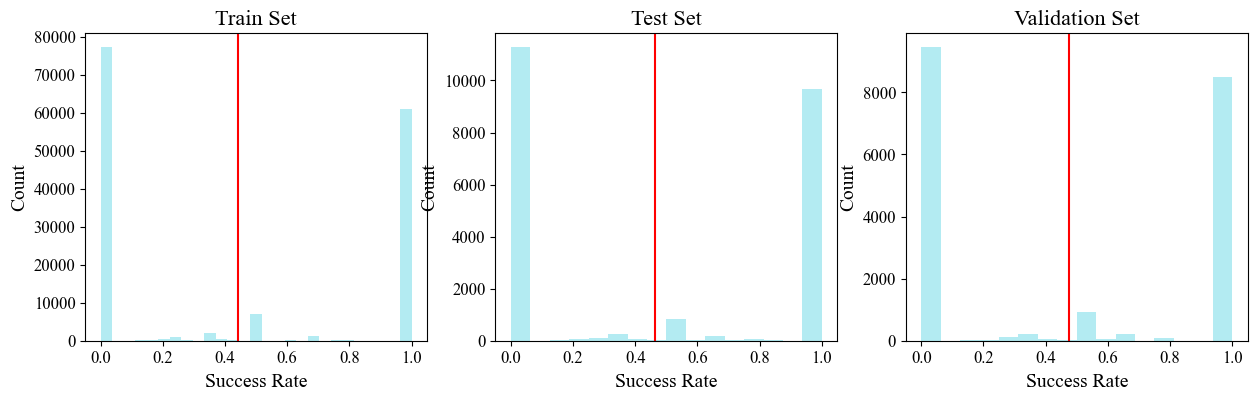

In [91]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_reg_dist(ax[0], site_success_train_labels, 'Success Rate', 'Count', 'Train Set')
plot_reg_dist(ax[1], site_success_test_labels, 'Success Rate', 'Count', 'Test Set')
plot_reg_dist(ax[2], site_success_val_labels, 'Success Rate', 'Count', 'Validation Set')

plt.savefig('site_success_dist.pdf')
plt.show()

/var/folders/0x/klqdyhpj427dvg81kxzyfcvm0000gn/T/ipykernel_93281/2293053390.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




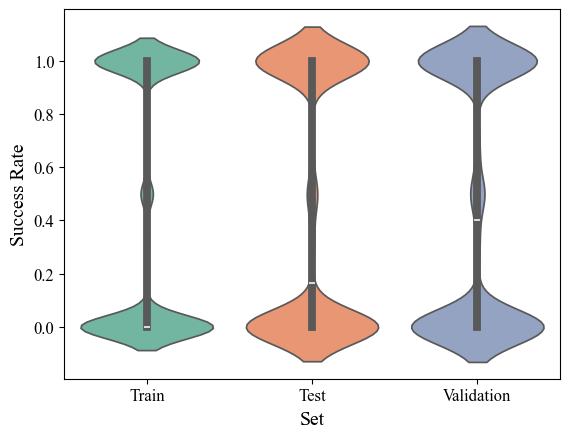

In [92]:
success_rate = np.concatenate([site_success_train_labels, site_success_test_labels, site_success_val_labels])
sets = (['Train'] * len(site_success_train_labels)) + (['Test'] * len(site_success_test_labels)) + (['Validation'] * len(site_success_val_labels))

df = pd.DataFrame({'Success Rate': success_rate, 'Set': sets})

fig, ax = plt.subplots()
sns.violinplot(x='Set', y='Success Rate', data=df, ax=ax, palette='Set2')

plt.savefig('site_success_violinplot.pdf')
plt.show()

In [93]:
%%sql train_df <<
from study_adverse_train

In [94]:
%%sql test_df <<
from study_adverse_test

In [95]:
%%sql val_df <<
from study_adverse_val

In [96]:
train_df.describe()

,timestamp,nct_id,num_of_adverse_events
count,43335,43335.000000,43335.000000
mean,2013-10-16 16:54:19.813083904,92183.386270,39.843268
min,2001-01-05 00:00:00,37.000000,0.000000
25%,2011-01-03 00:00:00,45384.000000,0.000000
50%,2014-01-02 00:00:00,86129.000000,2.000000
75%,2017-01-01 00:00:00,134732.500000,15.000000
max,2019-01-01 00:00:00,218391.000000,28085.000000
std,NaN,55048.973537,339.110533


In [97]:
test_df.describe()

,timestamp,nct_id,num_of_adverse_events
count,3098,3098.000000,3098.000000
mean,2021-01-01 00:00:00.000000256,198118.268238,57.930278
min,2021-01-01 00:00:00,315.000000,0.000000
25%,2021-01-01 00:00:00,174176.500000,0.000000
50%,2021-01-01 00:00:00,213002.500000,3.000000
75%,2021-01-01 00:00:00,233620.750000,24.000000
max,2021-01-01 00:00:00,249609.000000,5978.000000
std,NaN,47412.398715,249.726540


In [98]:
val_df.describe()

,timestamp,nct_id,num_of_adverse_events
count,3596,3596.000000,3596.000000
mean,2020-01-01 00:00:00.000000256,185187.685206,57.082870
min,2020-01-01 00:00:00,225.000000,0.000000
25%,2020-01-01 00:00:00,164685.250000,0.000000
50%,2020-01-01 00:00:00,197525.000000,2.000000
75%,2020-01-01 00:00:00,217057.500000,18.000000
max,2020-01-01 00:00:00,234821.000000,17245.000000
std,NaN,43167.668795,391.170094


In [99]:
study_adverse_train_labels = train_df.num_of_adverse_events.to_numpy()
study_adverse_test_labels = test_df.num_of_adverse_events.to_numpy()
study_adverse_val_labels = val_df.num_of_adverse_events.to_numpy()

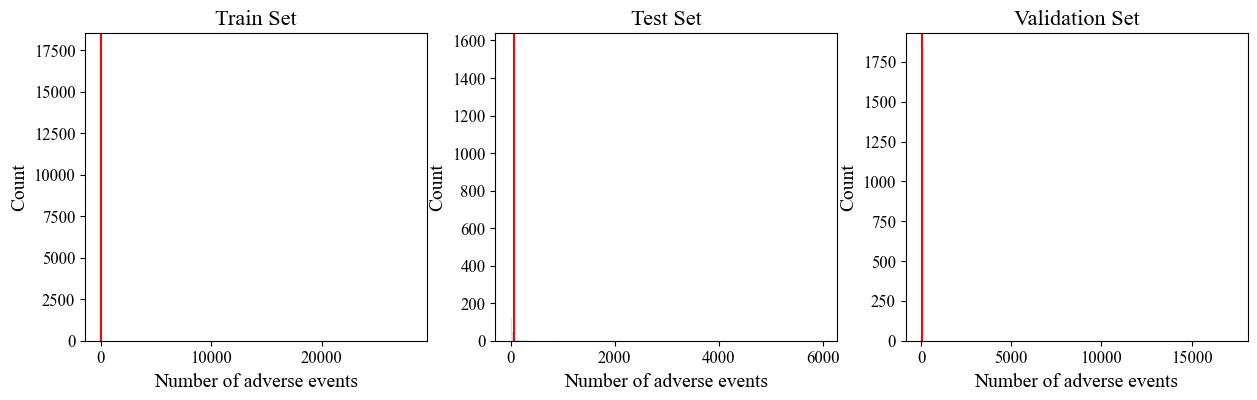

In [100]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_reg_dist(ax[0], study_adverse_train_labels, 'Number of adverse events', 'Count', 'Train Set')
plot_reg_dist(ax[1], study_adverse_test_labels, 'Number of adverse events', 'Count', 'Test Set')
plot_reg_dist(ax[2], study_adverse_val_labels, 'Number of adverse events', 'Count', 'Validation Set')

plt.savefig('study_adverse_dist.pdf')
plt.show()

/var/folders/0x/klqdyhpj427dvg81kxzyfcvm0000gn/T/ipykernel_93281/2622169434.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




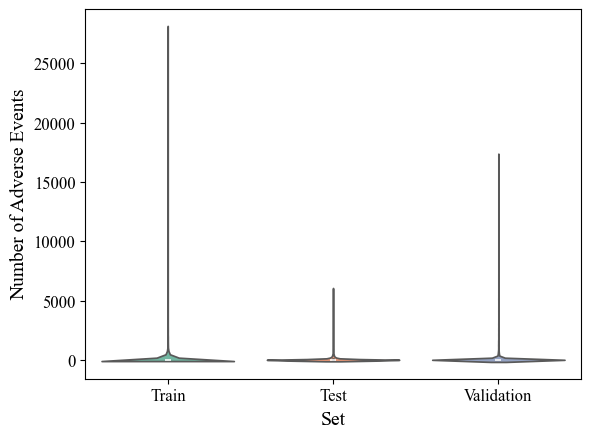

In [101]:
adverse = np.concatenate([study_adverse_train_labels, study_adverse_test_labels, study_adverse_val_labels])
sets = (['Train'] * len(study_adverse_train_labels)) + (['Test'] * len(study_adverse_test_labels)) + (['Validation'] * len(study_adverse_val_labels))

df = pd.DataFrame({'Number of Adverse Events': adverse, 'Set': sets})

fig, ax = plt.subplots()
sns.violinplot(x='Set', y='Number of Adverse Events', data=df, ax=ax, palette='Set2')

plt.savefig('study_adverse_violinplot.pdf')
plt.show()

In [102]:
conn.close()
gc.collect()

2489771

# Stack


In [103]:
conn = duckdb.connect('stack.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True
pio.renderers.default = 'svg'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [104]:
%%sql train_df <<
from user_engagement_train

In [105]:
%%sql test_df <<
from user_engagement_test

In [106]:
%%sql val_df <<
from user_engagement_val

In [107]:
train_df.describe()

,timestamp,OwnerUserId,contribution
count,1360850,1.360850e+06,1.360850e+06
mean,2017-11-13 17:06:43.704743680,5.871405e+04,4.998347e-02
min,2009-04-16 00:00:00,0.000000e+00,0.000000e+00
25%,2016-07-07 00:00:00,1.687100e+04,0.000000e+00
50%,2018-04-05 00:00:00,4.198400e+04,0.000000e+00
75%,2019-07-04 00:00:00,8.599100e+04,0.000000e+00
max,2020-07-02 00:00:00,2.525400e+05,1.000000e+00
std,NaN,5.317730e+04,2.179109e-01


In [108]:
test_df.describe()

,timestamp,OwnerUserId,contribution
count,88137,88137.000000,88137.000000
mean,2021-01-01 00:00:00,104481.995121,0.027355
min,2021-01-01 00:00:00,0.000000,0.000000
25%,2021-01-01 00:00:00,37569.000000,0.000000
50%,2021-01-01 00:00:00,88666.000000,0.000000
75%,2021-01-01 00:00:00,169146.000000,0.000000
max,2021-01-01 00:00:00,255358.000000,1.000000
std,NaN,75397.114417,0.163117


In [109]:
val_df.describe()

,timestamp,OwnerUserId,contribution
count,85838,85838.000000,85838.000000
mean,2020-10-01 00:00:00,100932.342016,0.028088
min,2020-10-01 00:00:00,0.000000,0.000000
25%,2020-10-01 00:00:00,36492.500000,0.000000
50%,2020-10-01 00:00:00,85743.500000,0.000000
75%,2020-10-01 00:00:00,163466.250000,0.000000
max,2020-10-01 00:00:00,252669.000000,1.000000
std,NaN,72878.547556,0.165225


In [110]:
user_engagement_train_labels = train_df.contribution.to_numpy()
user_engagement_test_labels = test_df.contribution.to_numpy()
user_engagement_val_labels = val_df.contribution.to_numpy()

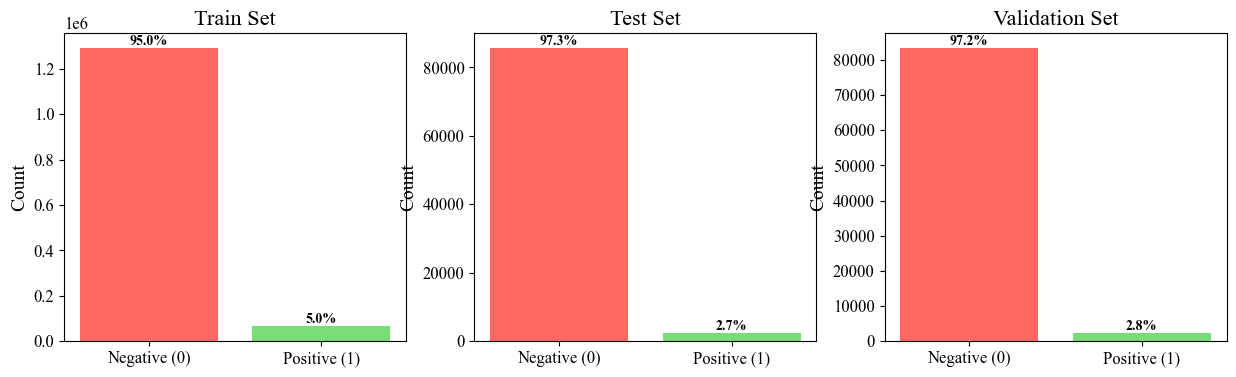

In [111]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_binary_dist(ax[0], user_engagement_train_labels, 'Count', 'Train Set')
plot_binary_dist(ax[1], user_engagement_test_labels, 'Count', 'Test Set')
plot_binary_dist(ax[2], user_engagement_val_labels, 'Count', 'Validation Set')

plt.savefig('user_engagement_dist.pdf')
plt.show()

In [112]:
conn.close()
gc.collect()

3882